# Document Similarity Matrix Clustering (DSMC)
#### Document Similarity Comparison and Clustering Using Similarity Matricies and Matrix Clustering Algorithms

In [398]:
# general imports
import string
import pandas as pd
import statistics
import numpy as np
from numpy import linalg as LA
import collections

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# SciPy imports
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

# SKLearn imports
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering

# MatPlotLib imports
import matplotlib.pyplot as plt

# TF-IDF imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [531]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## ETL

In [4]:
#load data
df = pd.read_csv('cts.csv')
df.head()

,CTS ID,CTS Resp ID,CTS Interview End Date,CTS - Prim Reason,CTS - Reason Comments
0,2,1441039,1/21/2019,'-,'-
1,3,1441589,1/7/2019,'-,'-
2,4,1441903,1/8/2019,'-,'-
3,5,1442068,1/9/2019,'-,'-
4,6,1442301,1/1/2019,'-,'-


In [5]:
# drop un neccesary columns
df1 = df.drop(['CTS ID', 'CTS Resp ID', 'CTS Interview End Date'], axis=1)

In [6]:
# reformat columns remaining names
df1.columns = ['cts_prime_reason', 'cts_prime_reason_comments']

In [7]:
# fix column dtype so that its dtype str
df1['cts_prime_reason'] = df1['cts_prime_reason'].astype('str')
df1['cts_prime_reason_comments'] = df1['cts_prime_reason_comments'].astype('str')

In [8]:
# view transformed dataframe
df1.head()

,cts_prime_reason,cts_prime_reason_comments
0,'-,'-
1,'-,'-
2,'-,'-
3,'-,'-
4,'-,'-


## Clean Data

In [342]:
# remove rows with prime reasons but no comment
options = ["'-", "Other"]

df2 = df1.loc[df1['cts_prime_reason'].isin(options)]
df2 = df2.loc[df2['cts_prime_reason_comments'] != "'-"]
df2 = df2.loc[df2['cts_prime_reason_comments'] != "nan"]
df2 = df2.loc[df2['cts_prime_reason_comments'] != "None"]

df2.head()

,cts_prime_reason,cts_prime_reason_comments
13,Other,Ease of Reporting Claim; representative's frie...
15,Other,I will always recommend Amica.
20,Other,Not satisfied.
29,Other,As I said above not in once in 25 years of cov...
34,Other,"I would recommend highly, and I actually have ..."


In [343]:
# create new column that assigns unique ID to each comment
df2['comment_id'] = range(0, 0 + len(df2))

In [344]:
# reset dataframe index for merging with the cluster output
df3 = df2
df3.reset_index(inplace=True)
df3.head()

,index,cts_prime_reason,cts_prime_reason_comments,comment_id
0,13,Other,Ease of Reporting Claim; representative's frie...,0
1,15,Other,I will always recommend Amica.,1
2,20,Other,Not satisfied.,2
3,29,Other,As I said above not in once in 25 years of cov...,3
4,34,Other,"I would recommend highly, and I actually have ...",4


In [345]:
# remove the new index column that was created because of the index reset
df4 = df3.drop(columns=['index'])
df4.head()

,cts_prime_reason,cts_prime_reason_comments,comment_id
0,Other,Ease of Reporting Claim; representative's frie...,0
1,Other,I will always recommend Amica.,1
2,Other,Not satisfied.,2
3,Other,As I said above not in once in 25 years of cov...,3
4,Other,"I would recommend highly, and I actually have ...",4


## Jaccard Similarity Functions

In [346]:
# remove stop words and lemmetizing the comments
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    lowered = str.lower(text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(lowered)

    words = []
    for w in word_tokens:
        if w not in stop_words:
            if w not in string.punctuation:
                if len(w) > 1:
                    lemmatized = lemmatizer.lemmatize(w)
                    words.append(lemmatized)
    return words

In [164]:
# calculate the jaccard similarity score between comments
def calculate_jaccard(word_tokens1, word_tokens2):
    # combine both tokens to find union
    both_tokens = word_tokens1 + word_tokens2
    union = set(both_tokens)

    # calculate intersection
    intersection = set()
    for w in word_tokens1:
        if w in word_tokens2:
            intersection.add(w)
        
    try:
        jaccard_score = len(intersection)/len(union)
    except:
        # catch edge case where the length of variable 'union' causes DivideByZero error
        jaccard_score = 0.0
        
    return jaccard_score

In [165]:
# tokenize all comments and calculate similarity scores for base comment vs all other comments
def process_jaccard_similarity():
    # tokenize the base document we are comparing against
    base_token = preprocess(base_comment)

    # tokenize all other documents
    all_tokens = []
    for i, comment in enumerate(comments):
        tokens = preprocess(comment)
        all_tokens.append(tokens)

    # calculate the jaccard similarity score and store all scores generated
    all_scores = []
    for tokens in all_tokens:
        score = calculate_jaccard(base_token, tokens)
        all_scores.append(score)
        
    return all_scores

## Create Jaccard Similarity Matrix   --(DO NOT NEED TO RUN)--

In [166]:
# calculate the similarity score between all documents
jaccard_dict = {}
comments = df4['cts_prime_reason_comments'].tolist()

for i in range(len(comments)):
    base_comment = df4.iloc[i,1]
    comment_index = df4.iloc[i,2]
    
    all_scores = process_jaccard_similarity()
    
    # dictionary that stores each comment and its similarity to every other comment
    jaccard_dict.update({comment_index: all_scores})

In [167]:
# turn the similarity dictionary into a dataframe creating a jaccard similarity matrix
jaccard_matrix = pd.DataFrame.from_dict(jaccard_dict)
jaccard_matrix

,0,1,2,3,4,5,6,7,8,9,...,563,564,565,566,567,568,569,570,571,572
0,1.000000,0.000000,0.0,0.0,0.037037,0.000000,0.047619,0.000000,0.000000,0.0,...,0.058824,0.000000,0.000000,0.062500,0.125000,0.031250,0.055556,0.055556,0.111111,0.055556
1,0.000000,1.000000,0.0,0.0,0.041667,0.000000,0.142857,0.076923,0.125000,0.0,...,0.200000,0.333333,0.080000,0.000000,0.000000,0.000000,0.181818,0.083333,0.000000,0.181818
2,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.034483,0.000000,0.000000,0.0,...,0.040000,0.000000,0.025000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.037037,0.041667,0.0,0.0,1.000000,0.000000,0.071429,0.017544,0.060000,0.0,...,0.037037,0.061224,0.044118,0.018519,0.037037,0.028986,0.075472,0.036364,0.035714,0.075472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0.031250,0.000000,0.0,0.0,0.028986,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.021277,0.032258,0.031250,1.000000,0.030303,0.030303,0.029412,0.000000
569,0.055556,0.181818,0.0,0.0,0.075472,0.083333,0.095238,0.050000,0.142857,0.0,...,0.055556,0.153846,0.030303,0.058824,0.055556,0.030303,1.000000,0.052632,0.050000,0.176471
570,0.055556,0.083333,0.0,0.0,0.036364,0.000000,0.000000,0.000000,0.000000,0.0,...,0.055556,0.000000,0.030303,0.058824,0.055556,0.030303,0.052632,1.000000,0.050000,0.000000
571,0.111111,0.000000,0.0,0.0,0.035714,0.000000,0.000000,0.047619,0.062500,0.0,...,0.000000,0.000000,0.000000,0.055556,0.111111,0.029412,0.050000,0.050000,1.000000,0.000000


## TF-IDF Similarity Function

In [302]:
def process_tfidf_similarity(base_document, documents):
    vectorizer = TfidfVectorizer()

    # To make uniformed vectors, both documents need to be combined first.
    documents.insert(0, base_document)
    embeddings = vectorizer.fit_transform(documents)

    cosine_similarities = cosine_similarity(embeddings[0:1], embeddings[1:]).flatten()

    return cosine_similarities

## Create TF-IDF Similarity Matrix

In [347]:
# calculate the similarity score between all documents
tfidf_dict = {}

for i in range(len(df4)):
    base_comment = df4.iloc[i,1]
    comment_index = df4.iloc[i,2]
    comments = df4['cts_prime_reason_comments'].tolist()
    
    all_scores = process_tfidf_similarity(base_comment, comments)
    
    # dictionary that stores each comment and its similarity to every other comment
    tfidf_dict.update({comment_index: all_scores})

In [348]:
# turn the similarity dictionary into a dataframe creating a jaccard similarity matrix
tfidf_matrix = pd.DataFrame.from_dict(tfidf_dict)
tfidf_matrix

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.000000,0.000000,0.000000,0.031433,0.055536,0.000000,0.000000,0.033910,0.000000,0.000000,...,0.058760,0.000000,0.031503,0.024658,0.157494,0.076722,0.084360,0.091599,0.180576,0.065014
1,0.000000,1.000000,0.000000,0.000000,0.062465,0.000000,0.110670,0.032233,0.092435,0.000000,...,0.186899,0.181323,0.087567,0.000000,0.000000,0.000000,0.098767,0.092772,0.000000,0.093798
2,0.000000,0.000000,1.000000,0.045791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.041913,0.000000,0.000000,0.046175,0.000000,0.000000,0.000000,0.000000
3,0.030942,0.000000,0.044823,1.000000,0.053850,0.038876,0.053707,0.047052,0.031350,0.033214,...,0.064568,0.012717,0.123932,0.026038,0.085677,0.135878,0.070564,0.119352,0.116249,0.032635
4,0.054940,0.060994,0.000000,0.054126,1.000000,0.000000,0.109440,0.123095,0.077141,0.040954,...,0.081104,0.099617,0.098060,0.044739,0.070713,0.073151,0.107804,0.103748,0.104878,0.183525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,0.075266,0.000000,0.045037,0.135468,0.072537,0.000000,0.000000,0.079834,0.000000,0.000000,...,0.017051,0.038335,0.071877,0.051515,0.041414,1.000000,0.110224,0.139393,0.120910,0.053077
567,0.083278,0.096210,0.000000,0.070782,0.107691,0.135511,0.063859,0.059182,0.201065,0.000000,...,0.083201,0.059490,0.068606,0.021870,0.061568,0.110915,1.000000,0.183432,0.146190,0.153923
568,0.090762,0.090628,0.000000,0.120157,0.103943,0.053734,0.000000,0.074970,0.096921,0.019933,...,0.096744,0.020259,0.106512,0.078280,0.095892,0.140792,0.184105,1.000000,0.225677,0.082882
569,0.177360,0.000000,0.000000,0.116288,0.104430,0.000000,0.000000,0.104329,0.093147,0.017205,...,0.049705,0.034975,0.062645,0.143616,0.163637,0.121397,0.145834,0.224324,1.000000,0.031040


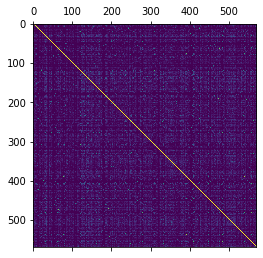

In [502]:
plt.matshow(tfidf_matrix)
plt.show()

## Optimization of K

1. Calculate affinity matrix based on input coordinates matrix and the number of nearest neighbours.
2. Apply local scaling based on the k nearest neighbour.

Reference:
- https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf

In [305]:
def getAffinityMatrix(coordinates, k=7):
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    
    return affinity_matrix

- Param A: Affinity matrix
- Param plot: plots the sorted eigen values for visual inspection
- Return a list containing the optimal number of clusters by eigengap heuristic
    
This method performs the eigen decomposition on a given affinity matrix, following the steps recommended in the paper:
1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
2. Find the eigenvalues and their associated eigen vectors
3. Identify the maximum gap which corresponds to the number of clusters by eigengap heuristic

References:
- https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
- http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf

In [306]:
def eigenDecomposition(A, plot=True, topK=5):
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest Eigen Values of Input Matrix')
        plt.xlabel('Count of Eigen Values')
        plt.ylabel('Eigen Value')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters 26


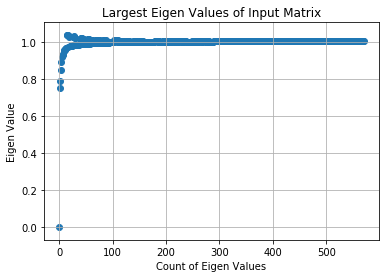

In [349]:
# create affinity matrix, calculate eigen gaps, plot values and return number of k
affinity_matrix = getAffinityMatrix(tfidf_matrix, k=10)
k, eigenvalues, eigenvectors = eigenDecomposition(affinity_matrix)

max_k = max(k)

print(f'Optimal number of clusters {max_k}')

## Assign Comments to Similarity Clusters

In [350]:
# assign comments to a cluster from the similarity matrix using spectral clustering
spec_clusters = SpectralClustering(max_k).fit_predict(tfidf_matrix)
spec_clusters[:10]

C:\Users\student\Anaconda3\lib\site-packages\sklearn\cluster\spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


array([ 1,  3,  1,  1, 14, 22, 19,  1, 12,  1])

In [351]:
# create a new dataframe containg all the cluster assignments in a column
df_clusters = pd.DataFrame(spec_clusters, columns=['cluster'])
df_clusters.head()

,cluster
0,1
1,3
2,1
3,1
4,14


In [352]:
# merge the cluster assignment dataframe with the original comments dataframe
df_merged = df4.merge(df_clusters, left_index=True, right_index=True)
df_merged.head()

,cts_prime_reason,cts_prime_reason_comments,comment_id,cluster
0,Other,Ease of Reporting Claim; representative's frie...,0,1
1,Other,I will always recommend Amica.,1,3
2,Other,Not satisfied.,2,1
3,Other,As I said above not in once in 25 years of cov...,3,1
4,Other,"I would recommend highly, and I actually have ...",4,14


In [353]:
# group rows based on their cluster assignment
grouped_df = df_merged.groupby('cluster')

In [354]:
# turn the grouped rows into lists of all the comments for that cluster in new dataframe
grouped_lists = grouped_df['cts_prime_reason_comments'].apply(list)
grouped_lists = grouped_lists.reset_index()
grouped_lists.head()

,cluster,cts_prime_reason_comments
0,0,"[See previous response, see answer on previous..."
1,1,[Ease of Reporting Claim; representative's fri...
2,2,"[excellent customer service, Excellent custome..."
3,3,"[I will always recommend Amica., I will always..."
4,4,"[Will definitely recommend!, I will recommend]"


In [530]:
# view the resulting list of lists containing all the comments that were assigned to the same cluster
grouped_lists['cts_prime_reason_comments'].iloc[25]

['Recommend because service is excellent.',
 'Would highly recommend, great customer service',
 'I would recommend because the service was excellent in all aspects.',
 'Strongly recommend Amica to everyone excellent service',
 'I would recommend Amica to everybody  because of the excellent service from the beginning to the end.',
 'I would and have recommend Amica because of their customer service.']

## Topic Keyword Analysis

In [500]:
# get top 3 most frequently used words in topic
def getWordCount(df, index):
    text_list = " ".join(df['cts_prime_reason_comments'].iloc[index])
    
    preprocess_text_list = preprocess(text_list)
    
    word_counts = collections.Counter(preprocess_text_list)
    word_count_df = pd.DataFrame.from_dict(word_counts, orient='index')
    
    word_count_df.columns = ['count']
    word_count_df1 = word_count_df.sort_values(by=['count'], ascending=False)
    word_count_df2 = word_count_df1.head(3)
    
    return word_count_df2

In [499]:
getWordCount(grouped_lists, 24)

,count
recommend,8
amica,7
always,4
